<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Dylan/Demo_Caiman_Stripped_Working_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The demo_pipeline file we've been working with uses some of the more advanced features of caiman which I think are throwing me off. 

This notebook is intended to implement a more stripped down version of the caiman pipeline with the goal of understanding the functions better and potentially being a platform to write our wrapper around for the parameter gridsearch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install CaImAn - takes around 2 minutes
!git clone https://github.com/flatironinstitute/CaImAn.git
%cd '/content/CaImAn/'
!pip install .

# Install caiman dependencies (&> /dev/null will suppress the hundreds of printed lines in the output)
!pip install -r requirements.txt &> /dev/null

#import other dependencies
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py

#Set up caiman
!python setup.py build_ext -i

#Other file setup
!python caimanmanager.py install --inplace

#Caiman imports
import caiman as cm
from caiman.paths import caiman_datadir
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.summary_images import local_correlations_movie_offline


Cloning into 'CaImAn'...
remote: Enumerating objects: 24886, done.
remote: Counting objects: 100% (821/821), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 24886 (delta 461), reused 723 (delta 406), pack-reused 24065
Receiving objects: 100% (24886/24886), 518.49 MiB | 27.52 MiB/s, done.
Resolving deltas: 100% (16674/16674), done.
Checking out files: 100% (317/317), done.
/content/CaImAn
Processing /content/CaImAn
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for caiman: filename=caiman-1.9.5-cp37-cp37m-linux_x86_64.whl size=123929419 sha256=08ed943f19821525f21635455e7ddee44435a184b8b1a29ec6563dca3889cd7

In [5]:
# Clone CaImAn from Github
#!git clone https://github.com/flatironinstitute/CaImAn.git

In [6]:
# Install CaImAn package
#%cd /content/CaImAn
#!pip install . 

In [7]:
# Install caiman dependencies
#!pip install -r requirements.txt

In [8]:
#!python setup.py build_ext -i

In [9]:
#!python caimanmanager.py install --inplace

In [ ]:
"""
Basic stripped-down demo for running the CNMF source extraction algorithm with
CaImAn and evaluation the components. The analysis can be run either in the
whole FOV or in patches. For a complete pipeline (including motion correction)
check demo_pipeline.py
Data courtesy of W. Yang, D. Peterka and R. Yuste (Columbia University)
This demo is designed to be run under spyder or jupyter; its plotting functions
are tailored for that environment.
@authors: @agiovann and @epnev


import cv2
import glob
import logging
import numpy as np
import os
import matplotlib.pyplot as plt


try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass


import caiman as cm
from caiman.paths import caiman_datadir
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.summary_images import local_correlations_movie_offline

"""

In [4]:
#Using h5py to open and explore a test raw stack
#paths into google drive to a random pre-motion correction movie
stackRaw = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/210725_1/210725_1_10_stackRaw_pmc_tm4_t5_syt_.mat', 'r+')


In [6]:
#save movie array as a variable to check a few frames
mov = np.array(stackRaw['stackRaw_pmc'])

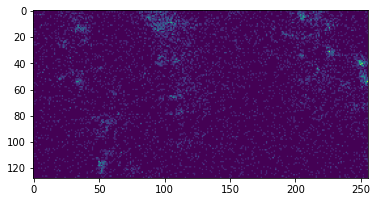

In [7]:
#numpy function to flip the x and y for whole movie array
flip = np.transpose(mov, axes = (0,2,1))
#show the 500th frame
plt.imshow(flip[500])

In [71]:
#save the first 500 frames back to an h5 file to test with
#This is just for development so we don't have to wait for processing times
h5f = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_pmc.h5', 'w')
h5f.create_dataset('mov', data=flip[:500])

h5f.close()

In [17]:
# %%
# Set up the logger; change this if you like.
# You can log to a file using the filename parameter, or make the output more or less
# verbose by setting level to logging.DEBUG, logging.INFO, logging.WARNING, or logging.ERROR

#logging.basicConfig(format=
#                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]"\
#                    "[%(process)d] %(message)s",
#                    level=logging.WARNING)
                    # filename="/tmp/caiman.log",



In [9]:
# start a cluster
c, dview, n_processes =\
    cm.cluster.setup_cluster(backend='local', n_processes=None,
                                 single_thread=False)

In [19]:
#dview.terminate()

In [73]:
#%% First setup some parameters for data and motion correction
# dataset dependent parameters

# ADJUSTED FROM DEFAULTS TO CARL'S PARAMS ON 11/13 (not completely)

fr = 20             # imaging rate in frames per second
decay_time = 0.4    # length of a typical transient in seconds
dxy = (2., 2.)      # spatial resolution in x and y in (um per pixel)
# note the lower than usual spatial resolution here
max_shift_um = (12., 12.)       # maximum shift in um
patch_motion_um = (100., 100.)  # patch size for non-rigid correction in um

# motion correction parameters
pw_rigid = False       # flag to select rigid vs pw_rigid motion correction
# maximum allowed rigid shift in pixels
max_shifts = [int(a/b) for a, b in zip(max_shift_um, dxy)]
# start a new patch for pw-rigid motion correction every x pixels
strides = tuple([int(a/b) for a, b in zip(patch_motion_um, dxy)])
# overlap between pathes (size of patch in pixels: strides+overlaps)
overlaps = (24, 24)
# maximum deviation allowed for patch with respect to rigid shifts
max_deviation_rigid = 3

opts = params.CNMFParams()

opts.set('motion', {
    'fnames': fnames,
    'fr': fr,
    'decay_time': decay_time,
    'dxy': dxy,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': 'copy'
    #'var_name_hdf5': 'stackRaw_pmc'
})




In [74]:
# set up some parameters for extraction
fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_pmc.h5']
                        # file(s) to be analyzed
is_patches = True       # flag for processing in patches or not
fr = 20                 # approximate frame rate of data
decay_time = .4        # length of transient

if is_patches:          # PROCESS IN PATCHES AND THEN COMBINE
    rf = 25             # half size of each patch
    stride = 5          # overlap between patches
    K = 3               # number of components in each patch
else:                   # PROCESS THE WHOLE FOV AT ONCE
    rf = None           # setting these parameters to None
    stride = None       # will run CNMF on the whole FOV
    K = 40              # number of neurons expected (in the whole FOV)

gSig = [6, 6]           # expected half size of neurons
merge_thresh = 0.95     # merging threshold, max correlation allowed
p = 0                   # order of the autoregressive system
gnb = 2                 # global background order

var_name_hdf5 = 'stackRaw_pmc' #variable to path caiman into the subfolder within our mat files

opts.set('data', {'fnames': fnames,
                   'fr': fr,
                   'decay_time': decay_time,
                   'rf': rf,
                   'stride': stride,
                   'K': K,
                   'gSig': gSig,
                   'merge_thr': merge_thresh,
                   'p': p,
                   'nb': gnb
                   #'var_name_hdf5': var_name_hdf5
                  })




In [75]:
# %% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier (this will pick up only neurons
#           and filter out active processes)

min_SNR = 2      # peak SNR for accepted components (if above this, acept)
rval_thr = 0.95     # space correlation threshold (if above this, accept)
use_cnn = True      # use the CNN classifier
min_cnn_thr = 0.90  # if cnn classifier predicts below this value, reject
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

opts.set('quality', {'min_SNR': min_SNR,
                                'rval_thr': rval_thr,
                                'use_cnn': use_cnn,
                                'min_cnn_thr': min_cnn_thr,
                                'cnn_lowest': cnn_lowest})

#cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)

In [88]:
opts

CNMFParams:

data:

{'caiman_version': '1.9.5',
 'decay_time': 0.4,
 'dims': None,
 'dxy': (1, 1),
 'fnames': ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_pmc.h5'],
 'fr': 20,
 'last_commit': 'GITW-a814402519f822d530f61f46d62840ca634e04d3',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': 32768,
 'nb': 1,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_deconvolution

In [57]:
#THIS FUCKING LINE IS ALL IT TOOK
#THE MOTION PARAMS DOES NOT PULL IN THE VAR NAME BY DEFAULT
#NEEDS TO BE MANUALLY INJECTED SO IT GETS PULLED INTO MOTION CORRECT WITH THE REST

#I think this causes problems in the next step because the save function doesn't expect this variable?
opts.motion['var_name_hdf5'] = 'stackRaw_pmc'

In [77]:
# %% Now RUN CaImAn Batch (CNMF)
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit_file(motion_correct = False, include_eval=True)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


ValueError: ignored

These cells only work if the fit function has gone through without errors

In [ ]:
import matplotlib.pyplot as plt
#3rd component
plt.figure() 
plt.imshow(np.reshape(cnm.estimates.A[:,2].toarray(), dims, order='F'))

In [ ]:
#deconvolved trace for 3rd component
plt.figure() 
plt.plot(cnm.estimates.C[2])

In [ ]:
#inferred spikes for 3rd component
plt.figure() 
plt.plot(cnm.estimates.S[2])

In [ ]:
#returns a list of our binary masks
M = cnm.estimates.A > 0
masks = [np.reshape(M[:,i].toarray(), dims, order='F') for i in range(M.shape[1])]

In [ ]:
#plot mask for 3rd ROI
plt.imshow(np.reshape(masks[2], dims, order='F'))

In [79]:
#Using h5py to see the saved output
import h5py
f = h5py.File(cnm.mmap_file[:-4]+'hdf5', 'r')


In [80]:
list(f.keys())

['dims', 'dview', 'params', 'remove_very_bad_comps', 'skip_refinement']

In [ ]:
f['dims'][()]

In [ ]:
f['dview'][()]

In [ ]:
f['remove_very_bad_comps'][()]

In [ ]:
f['skip_refinement'][()]

In [86]:
f['params']

<HDF5 group "/params" (1 members)>

In [81]:
#save gets through some of this then fails
f['params']['data'].keys()

<KeysViewHDF5 ['decay_time', 'dims', 'dxy', 'fnames', 'fr', 'var_name_hdf5']>

In [89]:
#this is the full section of dict that should be saved before it fails
cnm.params.data

{'caiman_version': '1.9.5',
 'decay_time': 0.4,
 'dims': None,
 'dxy': (1, 1),
 'fnames': ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_pmc.h5'],
 'fr': 20,
 'last_commit': 'GITW-a814402519f822d530f61f46d62840ca634e04d3',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

In [ ]:
f['params']['data']['decay_time'][()]

In [ ]:
f['params']['data']['dims'][()]

In [ ]:
f['params']['data']['dxy'][()]

In [ ]:
f['params']['data']['fnames'][()]

In [ ]:
f['params']['data']['fr'][()]

In [82]:
f['params']['data']['var_name_hdf5'][()]

b'mov'

In [ ]:
# %% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)